In [73]:
import os
import numpy as np
from astropy.io import fits
from astropy.time import Time
from astropy import units as u
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from astropy.coordinates import SkyCoord, EarthLocation 

//anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
//anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [78]:
from pylab import *
colormap='viridis'

cmap = cm.get_cmap(colormap, 53)
colors = []
for i in range(cmap.N):
    rgb = cmap(i)[:3]
    colors.append(matplotlib.colors.rgb2hex(rgb))
colors = np.array(colors)

In [2]:
directory = '/Users/arcticfox/Documents/atmospheres/v1298tau/reduced/'
aggressive = '/Users/arcticfox/Documents/atmospheres/v1298tau/reduced/re_re_reduced/'

In [9]:
files = os.listdir(directory)
files = np.sort([os.path.join(directory,fn) for fn in files if fn.endswith('m.fits.bz2')])
files = np.array(files, dtype='U100')
files1 = os.listdir(aggressive)
files1 = np.sort([os.path.join(aggressive,fn) for fn in files1 if fn.endswith('m.fits')])

for i in range(10,len(files)):
    files[i] = files1[i-10]

In [46]:
WAVELENGTH = np.load('alpha_wave.npy', allow_pickle=True)
SPECTRA = np.load('alpha_spec.npy', allow_pickle=True)
ORDERS = np.load('alpha_orders.npy', allow_pickle=True)

In [11]:
def get_time(files):
    times = np.zeros(len(files))
    for i in tqdm_notebook(range(len(files))):
        hdu = fits.open(files[i])
        times[i] = hdu[0].header['MJDATE']
        hdu.close()
    return times

In [92]:
def get_barycorr(times):
    corr = np.zeros(len(times))
    for i in tqdm_notebook(range(len(times))):
        keck = EarthLocation.from_geodetic(lat=19.8283*u.deg, 
                                   lon=-155.4783*u.deg, height=4160*u.m)
        sc = SkyCoord('04:05:19.6', '+20:09:25.6', unit=(u.hourangle, u.deg))
        barycorr = sc.radial_velocity_correction('heliocentric',
                                                 obstime=Time(times[i], format='jd'),
                                                 location=keck)
        bc = barycorr.to(u.km/u.s) 
        corr[i] = bc.value
    return corr

In [377]:
def barycentric_correction(wavelength, barycorr):
    wavelength_corr = np.zeros(len(wavelength), dtype=np.ndarray)
    speedlight = 2.998e8 * u.m / u.s
    # BARYCENTRIC CORRECTION
    for i in tqdm_notebook(range(len(wavelength))):
        w = wavelength[i] * u.nm
        bc = barycorr[i] * u.km / u.s
        dopshift = ((w * bc) / speedlight).to(u.nm)
        # CHANGED TO (-) 08/28/2020
        wavelength_corr[i] = (w - dopshift).to(u.nm).value 
    return wavelength_corr

In [161]:
def inject_rv(wave, rv, remove=False):
    c = 3e8 * u.m / u.s
    rv = rv * u.m / u.s
    wave = wave * u.nm
    factor = rv/c
    delta_wave = factor*wave
    
    if remove == False:
        return wave + delta_wave
    else:
        return wave - delta_wave

In [162]:
TIMES = get_time(files)
TIMES = Time(TIMES, format='mjd').jd
BARYCORR = get_barycorr(TIMES)

In [378]:
WAVELENGTH_CORR = barycentric_correction(WAVELENGTH, BARYCORR)

In [401]:
def grid_wavelength(wavelength, spectra, order, length):
    per_order = int(length/len(np.unique(order)))
    
    interp_waves = np.zeros((len(np.unique(order)), per_order))
    interp_spect = np.zeros((len(np.unique(order)), per_order))
    interp_order = np.zeros((len(np.unique(order)), per_order))
    
    for i, uo in enumerate(np.unique(order)):
        w, f = wavelength[order==uo], spectra[order==uo]

        redstart = w[0]
        blueend = w[-1]

        finer_wavelength = np.logspace(np.log10(redstart), np.log10(blueend),
                                       per_order, base=10.0)
        finer_wavelength[0] = redstart
        finer_wavelength[-1] = blueend
        
        f = interp1d(w, f)
        interp_spect[i] = f(finer_wavelength)
        interp_waves[i] = finer_wavelength
        interp_order[i] = np.full(per_order, uo)
    
    interp_waves = np.reshape(interp_waves, per_order*len(np.unique(order)))
    interp_spect = np.reshape(interp_spect, per_order*len(np.unique(order)))
    interp_order = np.reshape(interp_order, per_order*len(np.unique(order)))

    return interp_waves, interp_spect, interp_order

In [402]:
length = 1688916
FACTOR = 3

INTERPOLATED_WAVELENGTH = np.zeros( (len(WAVELENGTH), length) )
INTERPOLATED_SPECTRA    = np.zeros( (len(WAVELENGTH), length) )
INTERPOLATED_ORDERS     = np.zeros( (len(WAVELENGTH), length) )

for i in range(len(WAVELENGTH)):
    iw, iss, io = grid_wavelength(WAVELENGTH_CORR[i], SPECTRA[i], ORDERS[i], 562972*FACTOR)
    INTERPOLATED_WAVELENGTH[i] = iw
    INTERPOLATED_SPECTRA[i] = iss
    INTERPOLATED_ORDERS[i]  = io

In [403]:
np.save('barycentric_corrected_wavelength.npy', INTERPOLATED_WAVELENGTH)
np.save('barycentric_corrected_spectra.npy', INTERPOLATED_SPECTRA)
np.save('barycentric_corrected_orders.npy', INTERPOLATED_ORDERS)

In [329]:
binary = np.load('k2_mask.npy', allow_pickle=True)

inds = np.where((binary[0] >= WAVELENGTH[0][-1]) &
                (binary[0] <= WAVELENGTH[0][0]))[0]
binary = binary[:,inds]

which_orders = np.where( (WAVELENGTH[0] >= binary[0][0]) &
                         (WAVELENGTH[0] <= binary[0][-1]))[0] 
unique_orders = np.unique(ORDERS[0][which_orders])

In [384]:
rvs = np.linspace(-30000,30000,200) 

likelihoods = np.zeros( (len(unique_orders), len(WAVELENGTH_CORR), len(rvs)) )

for i in tqdm_notebook(range(len(WAVELENGTH_CORR))):
    
    for j, uo in enumerate(unique_orders):
        q = ORDERS[i] == uo
        
        interp = interp1d(WAVELENGTH_CORR[i][q], SPECTRA[i][q], kind='cubic')
        
        which_binary = np.where( (binary[0]>=WAVELENGTH_CORR[i][q][0]+1) &
                                 (binary[0]<=WAVELENGTH_CORR[i][q][-1]-1))[0]
        
        for r in range(len(rvs)):
            inject_wave = inject_rv(binary[0][which_binary], rvs[r])
            fit = interp(inject_wave) - 1
            likelihoods[j][i][r] = np.nansum(binary[1][which_binary] * fit)

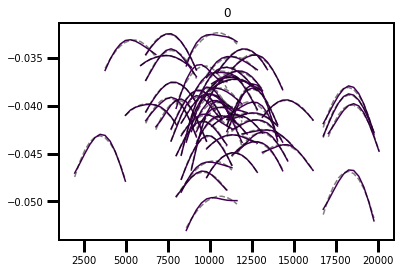

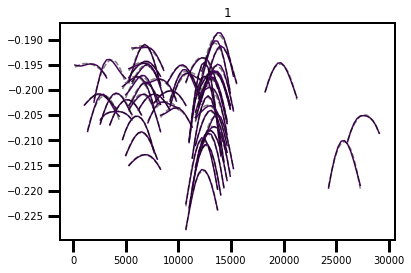

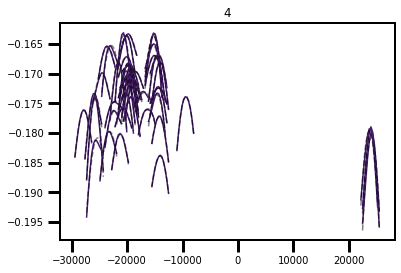

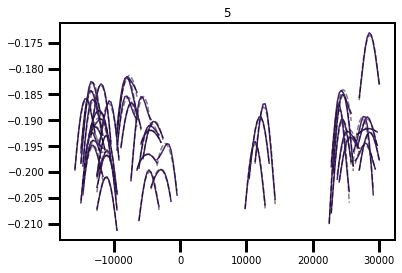

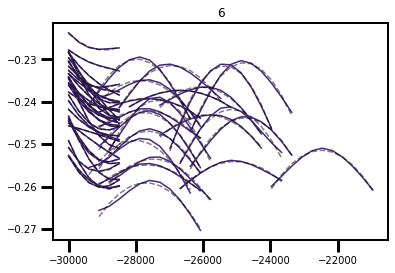

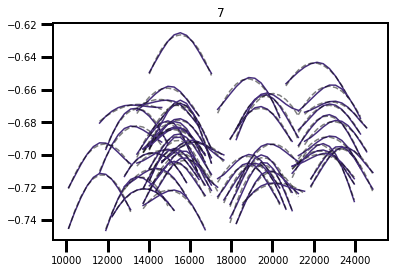

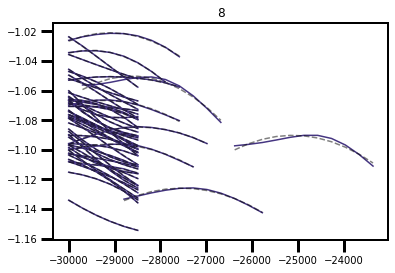

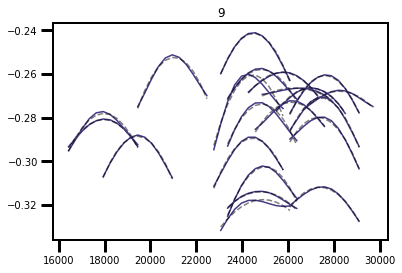

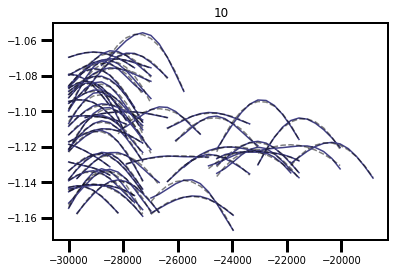

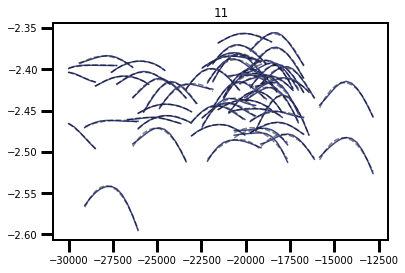

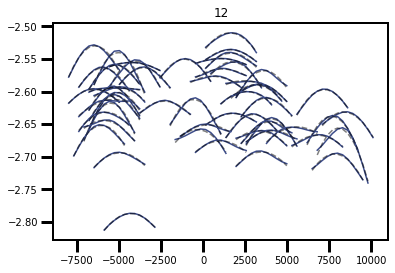

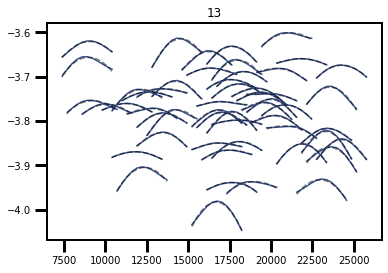

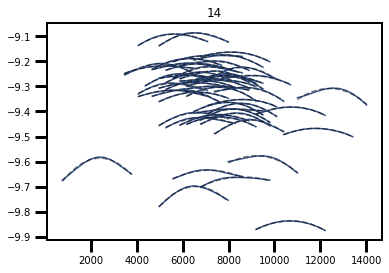

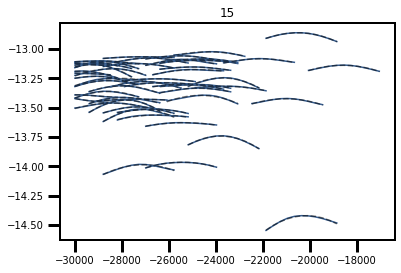

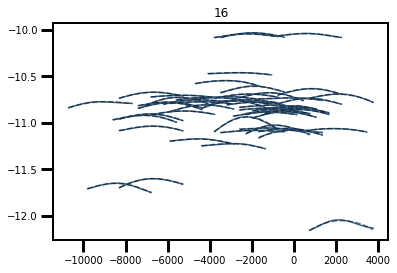

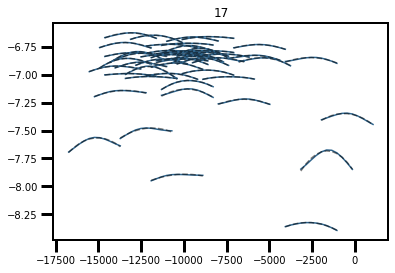

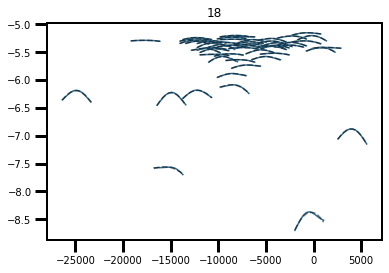

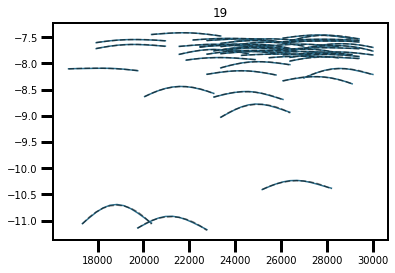

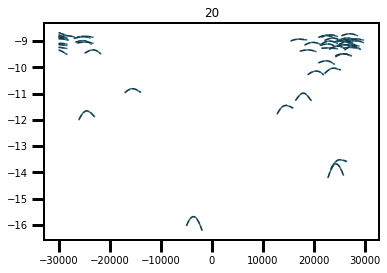

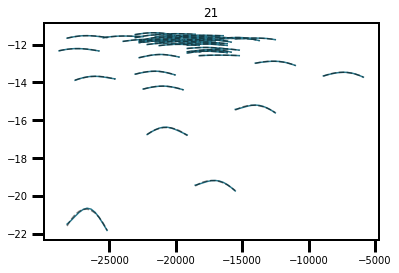

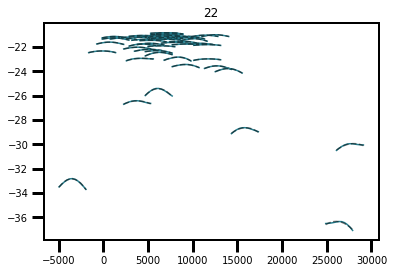

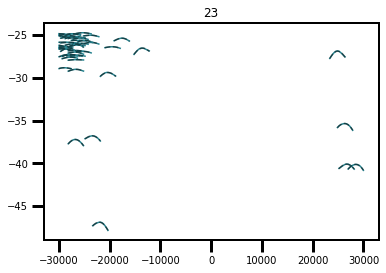

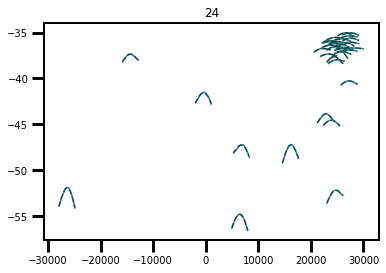

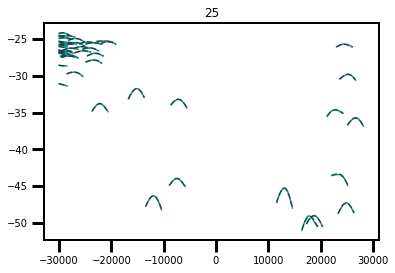

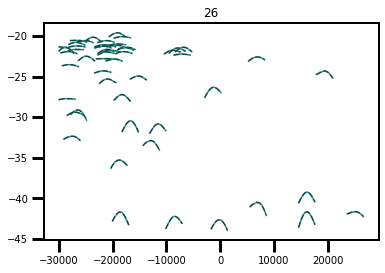

In [392]:
%matplotlib inline

binary_peaks = np.zeros((likelihoods.shape[0], likelihoods.shape[1]))

for i in range(likelihoods.shape[0]):
    fig, ax = plt.subplots()
    ax.set_facecolor('w')
    for j in range(likelihoods.shape[1]):
        
        if np.nanmedian(likelihoods[i][j]) != 0:
            
            x = np.arange(np.argmax(likelihoods[i][j])-5, 
                          np.argmax(likelihoods[i][j])+6, 1, dtype=int)
            check = np.where(x<0)[0]
            x = np.delete(x, check)
            #x = np.arange(0, len(likelihoods[i][j])-1, 1, dtype=int)
            try:
                plt.plot(rvs[x], likelihoods[i][j][x],
                         c=colors[i])
                # Fit the parabola to a smaller region
                fit = np.polyfit(rvs[x], likelihoods[i][j][x], deg=2)
                maximum = -fit[1]/(2*fit[0])
                model = np.poly1d(fit)
                plt.plot(rvs[x], model(rvs[x]), 'k--', alpha=0.5)
                binary_peaks[i][j] = maximum
            except:
                pass

    if np.nanmedian(likelihoods[i][j]) == 0:
        plt.close()
    else:
        plt.title(i)
        plt.show()
#plt.xlim(17000,20000)
#plt.ylim(0.99,1.01)

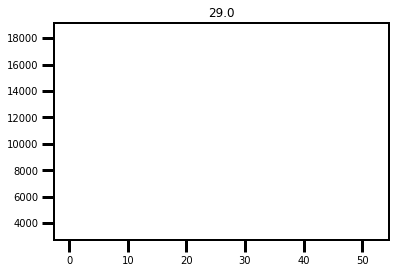

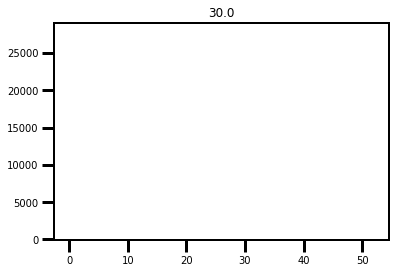

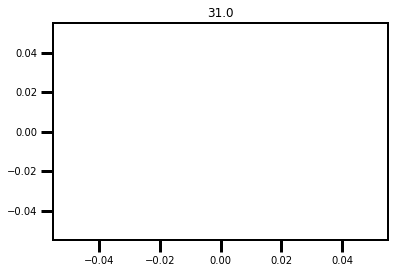

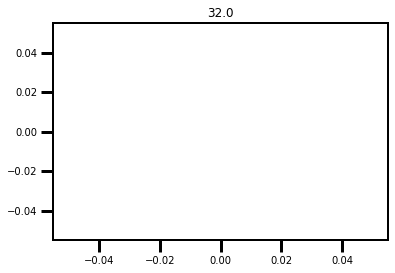

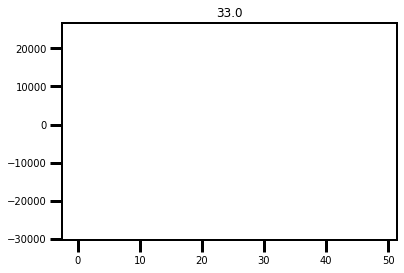

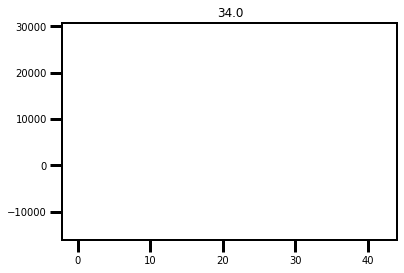

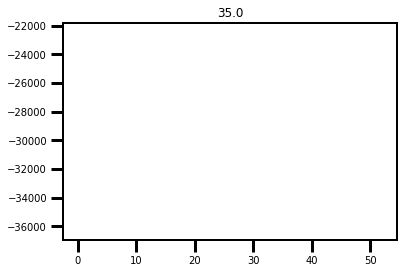

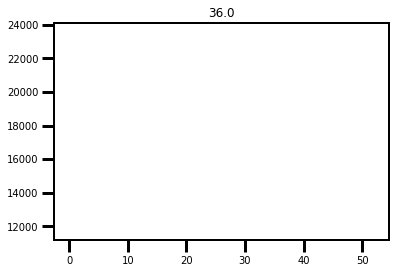

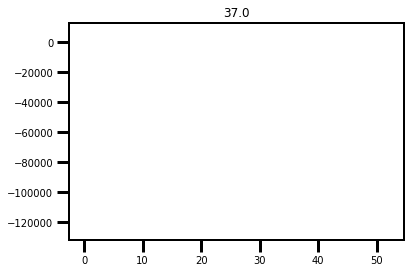

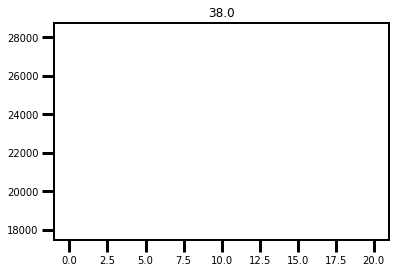

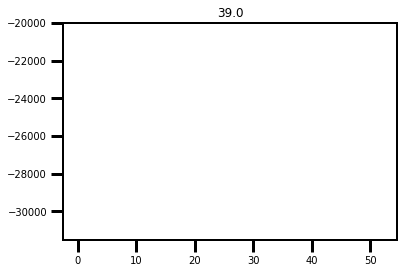

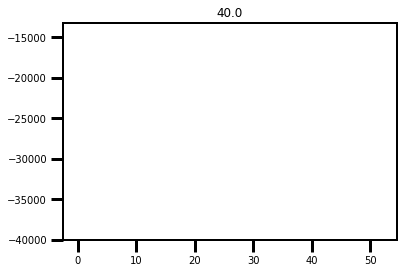

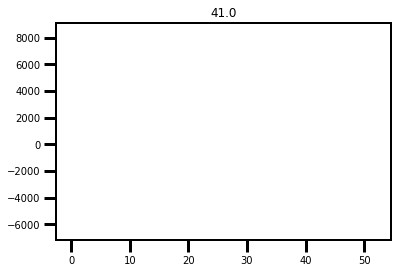

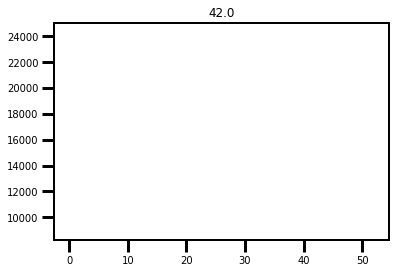

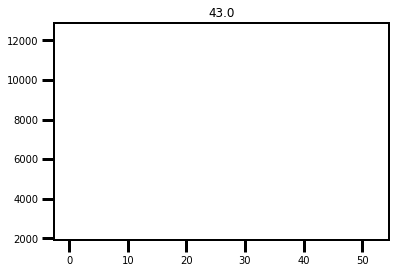

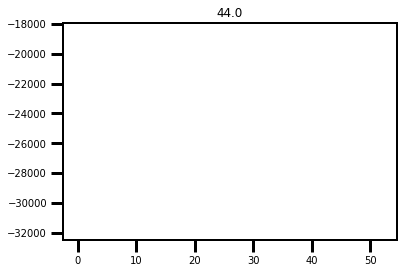

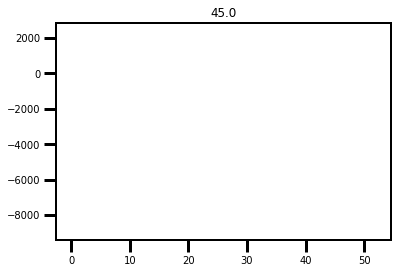

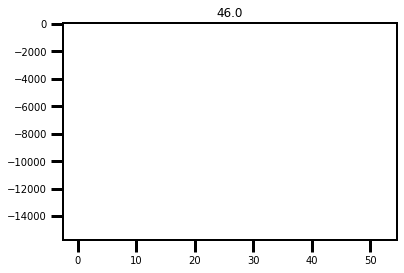

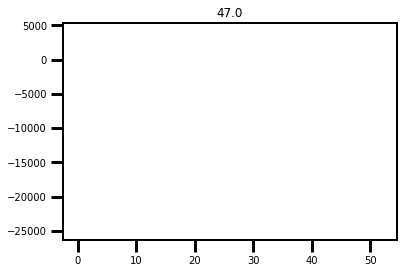

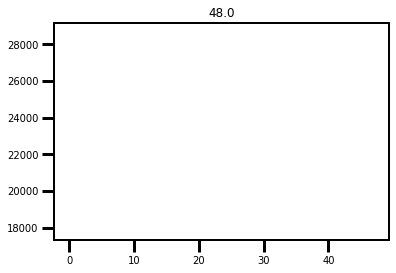

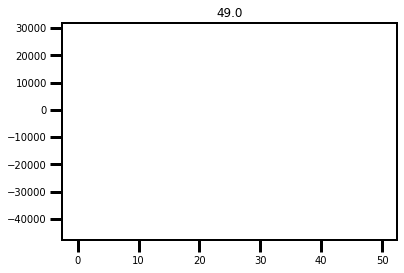

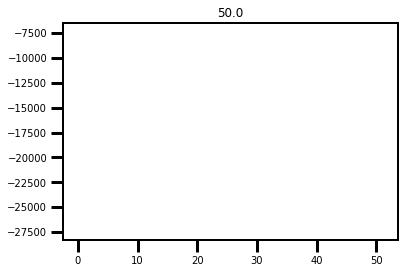

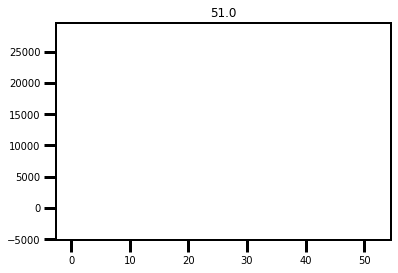

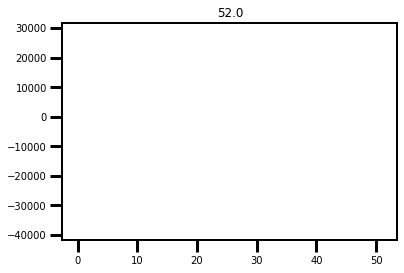

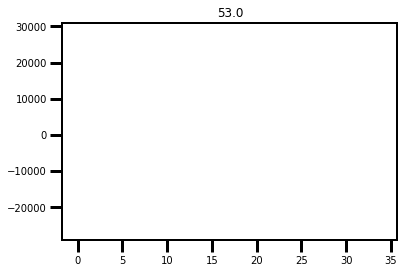

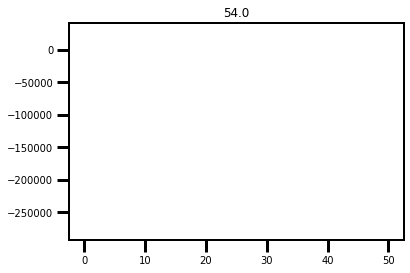

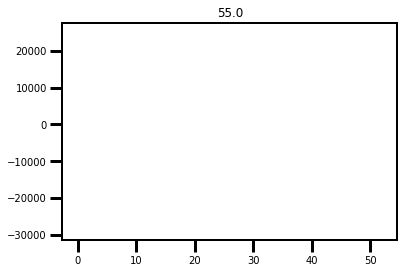

In [395]:
for i in range(len(binary_peaks)):
    plt.title(unique_orders[i])
    masky = binary_peaks[i] != 0
    plt.plot(binary_peaks[i][masky], 'wo')
    plt.show()

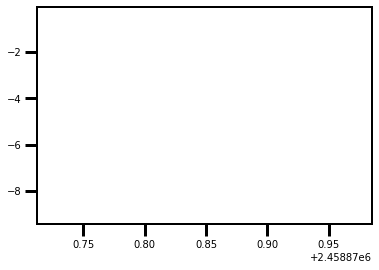

In [398]:
med_binary = np.nanmean(binary_peaks, axis=0) * u.m / u.s

#plt.plot(TIMES, med_binary.to(u.km/u.s), 'k.')
plt.plot(TIMES, med_binary.to(u.km/u.s), 'wo')
#plt.ylim(-25,-19)